<a href="https://colab.research.google.com/github/nk555/AI-Projects/blob/master/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST learns your handwriting

This is a small test of using a GAN to generate numbers that look as someone's handwriting when not trained on all numbers. For example we saw someone write the number 273 and we now predict how 481 looks like. 

Main inspiration for doing this is a paper I read recently on Star GAN v2. In this paper they try to recognize diferent latent spaces on the data used and making predictions. For example they are able to use image of different animals like dogs or tigers and making them look like a cat. 

For a small tutorial on how to write a GAN I looked at: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

Link to Star GAN v2: https://app.wandb.ai/stacey/stargan/reports/Cute-Animals-and-Post-Modern-Style-Transfer%3A-StarGAN-v2-for-Multi-Domain-Image-Synthesis---VmlldzoxNzcwODQ

# Initializing and Data preprocessing

In [20]:
import copy
import math
from collections import namedtuple
from copy import deepcopy
from functools import partial
import argparse

from munch import Munch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from skimage.filters import gaussian

import os
import shutil
from collections import OrderedDict

from torchvision import models
from scipy import linalg
from core.data_loader import get_eval_loader

In [4]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	# expand to 3d for using CNN
	X = expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	# normalize to [0,1]
	X = X / 255.0
	return X

# Helper Layers

In [ ]:
class ResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, actv=nn.LeakyReLU(0.2),
                 normalize=False, downsample=False):
        super().__init__()
        self.actv = actv
        self.normalize = normalize
        self.downsample = downsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out)

    def _build_weights(self, dim_in, dim_out):
        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
            self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.learned_sc:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.actv(x)
        x = self.conv1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x):
        x = self._shortcut(x) + self._residual(x)
        return x / math.sqrt(2)  # unit variance

In [ ]:
class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta

In [ ]:
class AdainResBlk(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=64, w_hpf=0,
                 actv=nn.LeakyReLU(0.2), upsample=False):
        super().__init__()
        self.w_hpf = w_hpf
        self.actv = actv
        self.upsample = upsample
        self.learned_sc = dim_in != dim_out
        self._build_weights(dim_in, dim_out, style_dim)

    def _build_weights(self, dim_in, dim_out, style_dim=64):
        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.norm2 = AdaIN(style_dim, dim_out)
        if self.learned_sc:
            self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.learned_sc:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.actv(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv1(x)
        x = self.norm2(x, s)
        x = self.actv(x)
        x = self.conv2(x)
        return x

    def forward(self, x, s):
        out = self._residual(x, s)
        if self.w_hpf == 0:
            out = (out + self._shortcut(x)) / math.sqrt(2)
        return out

In [ ]:
class InceptionV3(nn.Module):
    def __init__(self):
        super().__init__()
        inception = models.inception_v3(pretrained=True)
        self.block1 = nn.Sequential(
            inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.block2 = nn.Sequential(
            inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2))
        self.block3 = nn.Sequential(
            inception.Mixed_5b, inception.Mixed_5c,
            inception.Mixed_5d, inception.Mixed_6a,
            inception.Mixed_6b, inception.Mixed_6c,
            inception.Mixed_6d, inception.Mixed_6e)
        self.block4 = nn.Sequential(
            inception.Mixed_7a, inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d(output_size=(1, 1)))

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return x.view(x.size(0), -1)

In [ ]:
def normalize(x, eps=1e-10):
    return x * torch.rsqrt(torch.sum(x**2, dim=1, keepdim=True) + eps)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = models.alexnet(pretrained=True).features
        self.channels = []
        for layer in self.layers:
            if isinstance(layer, nn.Conv2d):
                self.channels.append(layer.out_channels)

    def forward(self, x):
        fmaps = []
        for layer in self.layers:
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                fmaps.append(x)
        return fmaps

In [ ]:
class Conv1x1(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.main = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False))

    def forward(self, x):
        return self.main(x)

In [ ]:
class LPIPS(nn.Module):
    def __init__(self):
        super().__init__()
        self.alexnet = AlexNet()
        self.lpips_weights = nn.ModuleList()
        for channels in self.alexnet.channels:
            self.lpips_weights.append(Conv1x1(channels, 1))
        self._load_lpips_weights()
        # imagenet normalization for range [-1, 1]
        self.mu = torch.tensor([-0.03, -0.088, -0.188]).view(1, 3, 1, 1).cuda()
        self.sigma = torch.tensor([0.458, 0.448, 0.450]).view(1, 3, 1, 1).cuda()

    def _load_lpips_weights(self):
        own_state_dict = self.state_dict()
        if torch.cuda.is_available():
            state_dict = torch.load('metrics/lpips_weights.ckpt')
        else:
            state_dict = torch.load('metrics/lpips_weights.ckpt',
                                    map_location=torch.device('cpu'))
        for name, param in state_dict.items():
            if name in own_state_dict:
                own_state_dict[name].copy_(param)

    def forward(self, x, y):
        x = (x - self.mu) / self.sigma
        y = (y - self.mu) / self.sigma
        x_fmaps = self.alexnet(x)
        y_fmaps = self.alexnet(y)
        lpips_value = 0
        for x_fmap, y_fmap, conv1x1 in zip(x_fmaps, y_fmaps, self.lpips_weights):
            x_fmap = normalize(x_fmap)
            y_fmap = normalize(y_fmap)
            lpips_value += torch.mean(conv1x1((x_fmap - y_fmap)**2))
        return lpips_value

In [ ]:
@torch.no_grad()
def calculate_lpips_given_images(group_of_images):
    # group_of_images = [torch.randn(N, C, H, W) for _ in range(10)]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lpips = LPIPS().eval().to(device)
    lpips_values = []
    num_rand_outputs = len(group_of_images)

    # calculate the average of pairwise distances among all random outputs
    for i in range(num_rand_outputs-1):
        for j in range(i+1, num_rand_outputs):
            lpips_values.append(lpips(group_of_images[i], group_of_images[j]))
    lpips_value = torch.mean(torch.stack(lpips_values, dim=0))
    return lpips_value.item()

In [ ]:
class HighPass(nn.Module):
    def __init__(self, w_hpf, device):
        super(HighPass, self).__init__()
        self.filter = torch.tensor([[-1, -1, -1],
                                    [-1, 8., -1],
                                    [-1, -1, -1]]).to(device) / w_hpf

    def forward(self, x):
        filter = self.filter.unsqueeze(0).unsqueeze(1).repeat(x.size(1), 1, 1, 1)
        return F.conv2d(x, filter, padding=1, groups=x.size(1))

# Discriminator Class

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_size=256, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, num_domains, 1, 1, 0)]
        self.main = nn.Sequential(*blocks)

    def forward(self, x, y):
        out = self.main(x)
        out = out.view(out.size(0), -1)  # (batch, num_domains)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        out = out[idx, y]  # (batch)
        return out

# Style Encoder Class (Latent Space)

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=64, num_domains=2):
        super().__init__()
        layers = []
        layers += [nn.Linear(latent_dim, 512)]
        layers += [nn.ReLU()]
        for _ in range(3):
            layers += [nn.Linear(512, 512)]
            layers += [nn.ReLU()]
        self.shared = nn.Sequential(*layers)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s

In [ ]:
class StyleEncoder(nn.Module):
    def __init__(self, img_size=256, style_dim=64, num_domains=2, max_conv_dim=512):
        super().__init__()
        dim_in = 2**14 // img_size
        blocks = []
        blocks += [nn.Conv2d(3, dim_in, 3, 1, 1)]

        repeat_num = int(np.log2(img_size)) - 2
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            blocks += [ResBlk(dim_in, dim_out, downsample=True)]
            dim_in = dim_out

        blocks += [nn.LeakyReLU(0.2)]
        blocks += [nn.Conv2d(dim_out, dim_out, 4, 1, 0)]
        blocks += [nn.LeakyReLU(0.2)]
        self.shared = nn.Sequential(*blocks)

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(dim_out, style_dim)]

    def forward(self, x, y):
        h = self.shared(x)
        h = h.view(h.size(0), -1)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)  # (batch, num_domains, style_dim)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        s = out[idx, y]  # (batch, style_dim)
        return s

# Metrics

In [ ]:
@torch.no_grad()
def calculate_metrics(nets, args, step, mode):
    print('Calculating evaluation metrics...')
    assert mode in ['latent', 'reference']
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    domains = os.listdir(args.val_img_dir)
    domains.sort()
    num_domains = len(domains)
    print('Number of domains: %d' % num_domains)

    lpips_dict = OrderedDict()
    for trg_idx, trg_domain in enumerate(domains):
        src_domains = [x for x in domains if x != trg_domain]

        if mode == 'reference':
            path_ref = os.path.join(args.val_img_dir, trg_domain)
            loader_ref = get_eval_loader(root=path_ref,
                                         img_size=args.img_size,
                                         batch_size=args.val_batch_size,
                                         imagenet_normalize=False,
                                         drop_last=True)

        for src_idx, src_domain in enumerate(src_domains):
            path_src = os.path.join(args.val_img_dir, src_domain)
            loader_src = get_eval_loader(root=path_src,
                                         img_size=args.img_size,
                                         batch_size=args.val_batch_size,
                                         imagenet_normalize=False)

            task = '%s2%s' % (src_domain, trg_domain)
            path_fake = os.path.join(args.eval_dir, task)
            shutil.rmtree(path_fake, ignore_errors=True)
            os.makedirs(path_fake)

            lpips_values = []
            print('Generating images and calculating LPIPS for %s...' % task)
            for i, x_src in enumerate(tqdm(loader_src, total=len(loader_src))):
                N = x_src.size(0)
                x_src = x_src.to(device)
                y_trg = torch.tensor([trg_idx] * N).to(device)
                masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

                # generate 10 outputs from the same input
                group_of_images = []
                for j in range(args.num_outs_per_domain):
                    if mode == 'latent':
                        z_trg = torch.randn(N, args.latent_dim).to(device)
                        s_trg = nets.mapping_network(z_trg, y_trg)
                    else:
                        try:
                            x_ref = next(iter_ref).to(device)
                        except:
                            iter_ref = iter(loader_ref)
                            x_ref = next(iter_ref).to(device)

                        if x_ref.size(0) > N:
                            x_ref = x_ref[:N]
                        s_trg = nets.style_encoder(x_ref, y_trg)

                    x_fake = nets.generator(x_src, s_trg, masks=masks)
                    group_of_images.append(x_fake)

                    # save generated images to calculate FID later
                    for k in range(N):
                        filename = os.path.join(
                            path_fake,
                            '%.4i_%.2i.png' % (i*args.val_batch_size+(k+1), j+1))
                        utils.save_image(x_fake[k], ncol=1, filename=filename)

                lpips_value = calculate_lpips_given_images(group_of_images)
                lpips_values.append(lpips_value)

            # calculate LPIPS for each task (e.g. cat2dog, dog2cat)
            lpips_mean = np.array(lpips_values).mean()
            lpips_dict['LPIPS_%s/%s' % (mode, task)] = lpips_mean

        # delete dataloaders
        del loader_src
        if mode == 'reference':
            del loader_ref
            del iter_ref

    # calculate the average LPIPS for all tasks
    lpips_mean = 0
    for _, value in lpips_dict.items():
        lpips_mean += value / len(lpips_dict)
    lpips_dict['LPIPS_%s/mean' % mode] = lpips_mean

    # report LPIPS values
    filename = os.path.join(args.eval_dir, 'LPIPS_%.5i_%s.json' % (step, mode))
    utils.save_json(lpips_dict, filename)

    # calculate and report fid values
    calculate_fid_for_all_tasks(args, domains, step=step, mode=mode)

In [ ]:
def calculate_fid_for_all_tasks(args, domains, step, mode):
    print('Calculating FID for all tasks...')
    fid_values = OrderedDict()
    for trg_domain in domains:
        src_domains = [x for x in domains if x != trg_domain]

        for src_domain in src_domains:
            task = '%s2%s' % (src_domain, trg_domain)
            path_real = os.path.join(args.train_img_dir, trg_domain)
            path_fake = os.path.join(args.eval_dir, task)
            print('Calculating FID for %s...' % task)
            fid_value = calculate_fid_given_paths(
                paths=[path_real, path_fake],
                img_size=args.img_size,
                batch_size=args.val_batch_size)
            fid_values['FID_%s/%s' % (mode, task)] = fid_value

    # calculate the average FID for all tasks
    fid_mean = 0
    for _, value in fid_values.items():
        fid_mean += value / len(fid_values)
    fid_values['FID_%s/mean' % mode] = fid_mean

    # report FID values
    filename = os.path.join(args.eval_dir, 'FID_%.5i_%s.json' % (step, mode))
    utils.save_json(fid_values, filename)

In [ ]:
def frechet_distance(mu, cov, mu2, cov2):
    cc, _ = linalg.sqrtm(np.dot(cov, cov2), disp=False)
    dist = np.sum((mu -mu2)**2) + np.trace(cov + cov2 - 2*cc)
    return np.real(dist)

In [ ]:
@torch.no_grad()
def calculate_fid_given_paths(paths, img_size=256, batch_size=50):
    print('Calculating FID given paths %s and %s...' % (paths[0], paths[1]))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inception = InceptionV3().eval().to(device)
    loaders = [get_eval_loader(path, img_size, batch_size) for path in paths]

    mu, cov = [], []
    for loader in loaders:
        actvs = []
        for x in tqdm(loader, total=len(loader)):
            actv = inception(x.to(device))
            actvs.append(actv)
        actvs = torch.cat(actvs, dim=0).cpu().detach().numpy()
        mu.append(np.mean(actvs, axis=0))
        cov.append(np.cov(actvs, rowvar=False))
    fid_value = frechet_distance(mu[0], cov[0], mu[1], cov[1])
    return fid_value

#Code from metrics/fid
if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument('--paths', type=str, nargs=2, help='paths to real and fake images')
  parser.add_argument('--img_size', type=int, default=256, help='image resolution')
  parser.add_argument('--batch_size', type=int, default=64, help='batch size to use')
  args = parser.parse_args()
  fid_value = calculate_fid_given_paths(args.paths, args.img_size, args.batch_size)
  print('FID: ', fid_value)

# Generator Class

In [ ]:
class Generator(nn.Module):
    def __init__(self, img_size=256, style_dim=64, max_conv_dim=512, w_hpf=1):
        super().__init__()
        dim_in = 2**14 // img_size
        self.img_size = img_size
        self.from_rgb = nn.Conv2d(3, dim_in, 3, 1, 1)
        self.encode = nn.ModuleList()
        self.decode = nn.ModuleList()
        self.to_rgb = nn.Sequential(
            nn.InstanceNorm2d(dim_in, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim_in, 3, 1, 1, 0))

        # down/up-sampling blocks
        repeat_num = int(np.log2(img_size)) - 4
        if w_hpf > 0:
            repeat_num += 1
        for _ in range(repeat_num):
            dim_out = min(dim_in*2, max_conv_dim)
            self.encode.append(
                ResBlk(dim_in, dim_out, normalize=True, downsample=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_in, style_dim,
                               w_hpf=w_hpf, upsample=True))  # stack-like
            dim_in = dim_out

        # bottleneck blocks
        for _ in range(2):
            self.encode.append(
                ResBlk(dim_out, dim_out, normalize=True))
            self.decode.insert(
                0, AdainResBlk(dim_out, dim_out, style_dim, w_hpf=w_hpf))

        if w_hpf > 0:
            device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
            self.hpf = HighPass(w_hpf, device)

    def forward(self, x, s, masks=None):
        x = self.from_rgb(x)
        cache = {}
        for block in self.encode:
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                cache[x.size(2)] = x
            x = block(x)
        for block in self.decode:
            x = block(x, s)
            if (masks is not None) and (x.size(2) in [32, 64, 128]):
                mask = masks[0] if x.size(2) in [32] else masks[1]
                mask = F.interpolate(mask, size=x.size(2), mode='bilinear')
                x = x + self.hpf(mask * cache[x.size(2)])
        return self.to_rgb(x)

# Training

In [ ]:
class Solver(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.nets, self.nets_ema = build_model(args)
        # below setattrs are to make networks be children of Solver, e.g., for self.to(self.device)
        for name, module in self.nets.items():
            utils.print_network(module, name)
            setattr(self, name, module)
        for name, module in self.nets_ema.items():
            setattr(self, name + '_ema', module)

        if args.mode == 'train':
            self.optims = Munch()
            for net in self.nets.keys():
                if net == 'fan':
                    continue
                self.optims[net] = torch.optim.Adam(
                    params=self.nets[net].parameters(),
                    lr=args.f_lr if net == 'mapping_network' else args.lr,
                    betas=[args.beta1, args.beta2],
                    weight_decay=args.weight_decay)

            self.ckptios = [
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets.ckpt'), **self.nets),
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets_ema.ckpt'), **self.nets_ema),
                CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_optims.ckpt'), **self.optims)]
        else:
            self.ckptios = [CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets_ema.ckpt'), **self.nets_ema)]

        self.to(self.device)
        for name, network in self.named_children():
            # Do not initialize the FAN parameters
            if ('ema' not in name) and ('fan' not in name):
                print('Initializing %s...' % name)
                network.apply(utils.he_init)

    def _save_checkpoint(self, step):
        for ckptio in self.ckptios:
            ckptio.save(step)

    def _load_checkpoint(self, step):
        for ckptio in self.ckptios:
            ckptio.load(step)

    def _reset_grad(self):
        for optim in self.optims.values():
            optim.zero_grad()

    def train(self, loaders):
        args = self.args
        nets = self.nets
        nets_ema = self.nets_ema
        optims = self.optims

        # fetch random validation images for debugging
        fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
        fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
        inputs_val = next(fetcher_val)

        # resume training if necessary
        if args.resume_iter > 0:
            self._load_checkpoint(args.resume_iter)

        # remember the initial value of ds weight
        initial_lambda_ds = args.lambda_ds

        print('Start training...')
        start_time = time.time()
        for i in range(args.resume_iter, args.total_iters):
            # fetch images and labels
            inputs = next(fetcher)
            x_real, y_org = inputs.x_src, inputs.y_src
            x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
            z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

            masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

            # train the discriminator
            d_loss, d_losses_latent = compute_d_loss(
                nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
            self._reset_grad()
            d_loss.backward()
            optims.discriminator.step()

            d_loss, d_losses_ref = compute_d_loss(
                nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
            self._reset_grad()
            d_loss.backward()
            optims.discriminator.step()

            # train the generator
            g_loss, g_losses_latent = compute_g_loss(
                nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
            self._reset_grad()
            g_loss.backward()
            optims.generator.step()
            optims.mapping_network.step()
            optims.style_encoder.step()

            g_loss, g_losses_ref = compute_g_loss(
                nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
            self._reset_grad()
            g_loss.backward()
            optims.generator.step()

            # compute moving average of network parameters
            moving_average(nets.generator, nets_ema.generator, beta=0.999)
            moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
            moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

            # decay weight for diversity sensitive loss
            if args.lambda_ds > 0:
                args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

            # print out log info
            if (i+1) % args.print_every == 0:
                elapsed = time.time() - start_time
                elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
                log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
                all_losses = dict()
                for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                        ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
                    for key, value in loss.items():
                        all_losses[prefix + key] = value
                all_losses['G/lambda_ds'] = args.lambda_ds
                log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
                print(log)

            # generate images for debugging
            if (i+1) % args.sample_every == 0:
                os.makedirs(args.sample_dir, exist_ok=True)
                utils.debug_image(nets_ema, args, inputs=inputs_val, step=i+1)

            # save model checkpoints
            if (i+1) % args.save_every == 0:
                self._save_checkpoint(step=i+1)

            # compute FID and LPIPS if necessary
            if (i+1) % args.eval_every == 0:
                calculate_metrics(nets_ema, args, i+1, mode='latent')
                calculate_metrics(nets_ema, args, i+1, mode='reference')

    @torch.no_grad()
    def sample(self, loaders):
        args = self.args
        nets_ema = self.nets_ema
        os.makedirs(args.result_dir, exist_ok=True)
        self._load_checkpoint(args.resume_iter)

        src = next(InputFetcher(loaders.src, None, args.latent_dim, 'test'))
        ref = next(InputFetcher(loaders.ref, None, args.latent_dim, 'test'))

        fname = ospj(args.result_dir, 'reference.jpg')
        print('Working on {}...'.format(fname))
        utils.translate_using_reference(nets_ema, args, src.x, ref.x, ref.y, fname)

        fname = ospj(args.result_dir, 'video_ref.mp4')
        print('Working on {}...'.format(fname))
        utils.video_ref(nets_ema, args, src.x, ref.x, ref.y, fname)

    @torch.no_grad()
    def evaluate(self):
        args = self.args
        nets_ema = self.nets_ema
        resume_iter = args.resume_iter
        self._load_checkpoint(args.resume_iter)
        calculate_metrics(nets_ema, args, step=resume_iter, mode='latent')
        calculate_metrics(nets_ema, args, step=resume_iter, mode='reference')

In [ ]:
def compute_d_loss(nets, args, x_real, y_org, y_trg, z_trg=None, x_ref=None, masks=None):
    assert (z_trg is None) != (x_ref is None)
    # with real images
    x_real.requires_grad_()
    out = nets.discriminator(x_real, y_org)
    loss_real = adv_loss(out, 1)
    loss_reg = r1_reg(out, x_real)

    # with fake images
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg)
        else:  # x_ref is not None
            s_trg = nets.style_encoder(x_ref, y_trg)

        x_fake = nets.generator(x_real, s_trg, masks=masks)
    out = nets.discriminator(x_fake, y_trg)
    loss_fake = adv_loss(out, 0)

    loss = loss_real + loss_fake + args.lambda_reg * loss_reg
    return loss, Munch(real=loss_real.item(),
                       fake=loss_fake.item(),
                       reg=loss_reg.item())

In [ ]:
def compute_g_loss(nets, args, x_real, y_org, y_trg, z_trgs=None, x_refs=None, masks=None):
    assert (z_trgs is None) != (x_refs is None)
    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
    if x_refs is not None:
        x_ref, x_ref2 = x_refs

    # adversarial loss
    if z_trgs is not None:
        s_trg = nets.mapping_network(z_trg, y_trg)
    else:
        s_trg = nets.style_encoder(x_ref, y_trg)

    x_fake = nets.generator(x_real, s_trg, masks=masks)
    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    # style reconstruction loss
    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = torch.mean(torch.abs(s_pred - s_trg))

    # diversity sensitive loss
    if z_trgs is not None:
        s_trg2 = nets.mapping_network(z_trg2, y_trg)
    else:
        s_trg2 = nets.style_encoder(x_ref2, y_trg)
    x_fake2 = nets.generator(x_real, s_trg2, masks=masks)
    x_fake2 = x_fake2.detach()
    loss_ds = torch.mean(torch.abs(x_fake - x_fake2))

    # cycle-consistency loss
    masks = nets.fan.get_heatmap(x_fake) if args.w_hpf > 0 else None
    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org, masks=masks)
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))

    loss = loss_adv + args.lambda_sty * loss_sty \
        - args.lambda_ds * loss_ds + args.lambda_cyc * loss_cyc
    return loss, Munch(adv=loss_adv.item(),
                       sty=loss_sty.item(),
                       ds=loss_ds.item(),
                       cyc=loss_cyc.item())

In [ ]:
def moving_average(model, model_test, beta=0.999):
    for param, param_test in zip(model.parameters(), model_test.parameters()):
        param_test.data = torch.lerp(param.data, param_test.data, beta)

In [ ]:
def adv_loss(logits, target):
    assert target in [1, 0]
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss

In [ ]:
def r1_reg(d_out, x_in):
    # zero-centered gradient penalty for real images
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

# Building the Model

In [ ]:
def build_model(args):
    generator = Generator(args.img_size, args.style_dim, w_hpf=args.w_hpf)
    mapping_network = MappingNetwork(args.latent_dim, args.style_dim, args.num_domains)
    style_encoder = StyleEncoder(args.img_size, args.style_dim, args.num_domains)
    discriminator = Discriminator(args.img_size, args.num_domains)
    generator_ema = copy.deepcopy(generator)
    mapping_network_ema = copy.deepcopy(mapping_network)
    style_encoder_ema = copy.deepcopy(style_encoder)

    nets = Munch(generator=generator,
                 mapping_network=mapping_network,
                 style_encoder=style_encoder,
                 discriminator=discriminator)
    nets_ema = Munch(generator=generator_ema,
                     mapping_network=mapping_network_ema,
                     style_encoder=style_encoder_ema)

    if args.w_hpf > 0:
        fan = FAN(fname_pretrained=args.wing_path).eval()
        nets.fan = fan
        nets_ema.fan = fan

    return nets, nets_ema

# Predicting

In [ ]:
def get_preds_fromhm(hm):
    max, idx = torch.max(
        hm.view(hm.size(0), hm.size(1), hm.size(2) * hm.size(3)), 2)
    idx += 1
    preds = idx.view(idx.size(0), idx.size(1), 1).repeat(1, 1, 2).float()
    preds[..., 0].apply_(lambda x: (x - 1) % hm.size(3) + 1)
    preds[..., 1].add_(-1).div_(hm.size(2)).floor_().add_(1)

    for i in range(preds.size(0)):
        for j in range(preds.size(1)):
            hm_ = hm[i, j, :]
            pX, pY = int(preds[i, j, 0]) - 1, int(preds[i, j, 1]) - 1
            if pX > 0 and pX < 63 and pY > 0 and pY < 63:
                diff = torch.FloatTensor(
                    [hm_[pY, pX + 1] - hm_[pY, pX - 1],
                     hm_[pY + 1, pX] - hm_[pY - 1, pX]])
                preds[i, j].add_(diff.sign_().mul_(.25))

    preds.add_(-0.5)
    return preds

# Extras

In [ ]:
class HighPass(nn.Module):
    def __init__(self, w_hpf, device):
        super(HighPass, self).__init__()
        self.filter = keras.tensor([[-1, -1, -1],
                                    [-1, 8., -1],
                                    [-1, -1, -1]]).to(device) / w_hpf

    def forward(self, x):
        filter = self.filter.unsqueeze(0).unsqueeze(1).repeat(x.size(1), 1, 1, 1)
        return keras.Functional.conv2d(x, filter, padding=1, groups=x.size(1))

In [6]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [7]:
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [8]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [9]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [10]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [11]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [12]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [13]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [25]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [15]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
			if (i+1) % 10 == 0:
				summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [16]:
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [17]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Se han truncado las últimas 5000 líneas del flujo de salida.
>81, 150/234, d=0.689, g=0.689
>81, 151/234, d=0.684, g=0.681
>81, 152/234, d=0.696, g=0.707
>81, 153/234, d=0.700, g=0.726
>81, 154/234, d=0.689, g=0.737
>81, 155/234, d=0.689, g=0.720
>81, 156/234, d=0.688, g=0.710
>81, 157/234, d=0.690, g=0.679
>81, 158/234, d=0.691, g=0.682
>81, 159/234, d=0.689, g=0.684
>81, 160/234, d=0.695, g=0.696
>81, 161/234, d=0.694, g=0.718
>81, 162/234, d=0.691, g=0.717
>81, 163/234, d=0.691, g=0.693
>81, 164/234, d=0.693, g=0.679
>81, 165/234, d=0.694, g=0.707
>81, 166/234, d=0.696, g=0.717
>81, 167/234, d=0.689, g=0.719
>81, 168/234, d=0.689, g=0.709
>81, 169/234, d=0.692, g=0.691
>81, 170/234, d=0.691, g=0.687
>81, 171/234, d=0.692, g=0.689
>81, 172/234, d=0.690, g=0.700
>81, 173/234, d=0.685, g=0.713
>81, 174/234, d=0.689, g=0.715
>81, 175/234, d=0.692, g=0.697
>81, 176/234, d=0.694, g=0.680
>81, 177/234, d=0.702, g=0.703
>81, 178/234, d=0.694, g=0.705
>81, 179/234, d=0.682, g=0.707
>81, 180/

In [29]:
filename = 'generator_model_100.h5'
g_model.save(filename)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


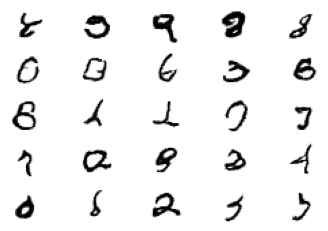

In [31]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)